In [ ]:
import os
import sys
import dcor
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split

from dowhy import CausalModel

from typing import List

root_path = root_path = os.path.realpath('../..')
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from causaltune import CausalTune
from causaltune.scoring import Scorer
from causaltune.datasets import iv_dgp_econml
from causaltune.params import SimpleParamService
from causaltune.utils import treatment_is_multivalue

warnings.filterwarnings("ignore")

### Model fitting & scoring

Here we fit a (selection of) model(s) to the data and score them with the energy distance score on held-out data.

We create a synthetic dataset and pre-process it with a DGP described [here](https://github.com/microsoft/EconML/blob/main/notebooks/OrthoIV%20and%20DRIV%20Examples.ipynb). The dataset size, number of features and constant true effect, can be varied.

In [2]:
TE = 11.50
cd = iv_dgp_econml(n=10000, p=15, true_effect=TE)

outcome = cd.outcomes[0]
print(f'treatment: {cd.treatment}')
print(f'instrument(s): {cd.instruments}')
print(f'outcome: {cd.outcomes}')

cd.data.head()

treatment: treatment
instrument(s): ['Z']
outcome: ['y']


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,y,treatment,Z,random
0,-0.329564,0.507912,0.057014,2.290009,0.761324,0.256767,0.339125,-0.353322,0.346981,-1.556023,0.507205,-0.402164,0.437588,-0.458120,-1.352908,22.405589,1,1,0
1,1.365297,-0.701692,-2.430485,1.720417,-0.193000,-1.110424,0.841162,0.250974,-2.217757,-1.044864,0.102841,-0.847315,0.094363,0.227982,-1.020588,8.082531,0,1,1
2,-0.508284,-0.958345,-0.446887,0.580817,-1.450001,0.079382,0.132708,0.855452,-0.378823,-0.241491,2.187245,1.291656,0.816625,-0.944377,-0.979433,12.542363,0,0,1
3,-1.524213,-0.053568,0.998427,-1.362509,1.289621,0.662573,-2.324185,-1.485730,-0.422057,1.061165,-0.686730,-0.174196,-0.412696,1.183159,0.114383,4.937131,0,0,0
4,-0.573930,-0.654429,-1.514024,0.999593,-0.200975,0.619909,-1.017617,-0.157695,-0.573914,1.755003,-0.971867,-1.766156,0.101116,0.560461,0.056618,6.377113,0,1,0


If you want to use specific estimators, pass these as a list to `estimator_list` param in `CausalTune`. IV estimators are listed in `all_estimators` below.

The other allowed values are `all` and `auto`, the default is `auto`.

For IV models, currently specify `auto` for propensity model, and instruments when

Fitting the model is as simple as calling CausalTune.fit(), with the only required parameter apart from the data being the `instruments` for IV models.



In [ ]:
estimator_list = ["DMLIV"] #, "OrthoIV", "LinearDRIV", "SparseLinearDRIV", "LinearIntentToTreatDRIV"]
ct = CausalTune(
    #time_budget=100,
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    components_time_budget=30,
    propensity_model="auto",
)

ct.fit(data=cd, outcome=outcome)

In [4]:
ct_estimator_effect = ct.model.effect(ct.test_df).mean()
print(f'ATE estimate: {ct_estimator_effect}')

ATE estimate: 5.654930047167262


In [6]:
print("(Causaltune Estimator)")
print(f"Estimator: {ct.best_estimator}")
print(f"Config: {ct.best_config}")
print(f"Energy distance score: {ct.best_score}")

(Causaltune Estimator)
Estimator: iv.econml.iv.dml.DMLIV
Config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}
Energy distance score: 1.7086967276755596


### Baseline Estimators

For comparison, we take the best default configuration of all integrated IV estimators as a baseline, and compare the ATE and energy distance scores, with the best CausalTune configuration.

In [7]:
params = SimpleParamService(propensity_model=None, outcome_model=None, multivalue=treatment_is_multivalue(cd.treatment))
iv_estimators = ["iv.econml.iv.dml.DMLIV"] # params.estimator_names_from_patterns("iv", "auto")

In [8]:
# Baseline comparisons: IV models with default conigurations
baseline_scores = {}
for est_name in iv_estimators:
    model = CausalModel(
        data=ct.train_df,
        treatment=cd.treatment,
        outcome=outcome,
        effect_modifiers=cd.effect_modifiers,
        common_causes=["random"],
        instruments=cd.instruments,
    )
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    estimate = model.estimate_effect(
        identified_estimand,
        method_name=est_name,
        method_params={
            "init_params": {},
            "fit_params": {},
        },
        test_significance=False,
    )

    base_effect_ = estimate.estimator.effect(ct.test_df).mean()
    base_energy_dist = Scorer.energy_distance_score(estimate, ct.test_df)

    baseline_scores[est_name] = {
        "effect": base_effect_,
        "energy_distance": base_energy_dist
    }

baseline_estimator, baseline_metrics = sorted(baseline_scores.items(), key=lambda x: x[1]["energy_distance"])[0]

print("(Best baseline)")
print("Estimator: ", baseline_estimator)
print("Energy distance score: ", baseline_metrics["energy_distance"])


(Best baseline)
Estimator:  iv.econml.iv.dml.DMLIV
Energy distance score:  0.015361269028806745


#### Comparing Treatment Effect

In [9]:
print("True Treatment Effect  = ", TE)
print("(Baseline) Treatment Effect: ", baseline_metrics["effect"])
print("(CausalTune) Treatment Effect: ", ct_estimator_effect)

True Treatment Effect  =  11.5
(Baseline) Treatment Effect:  11.902863347795355
(CausalTune) Treatment Effect:  5.654930047167262


In [10]:
# Needed since ct.model.estimator doesn't include additional params -
# treatment, outcome etc. - needed from CausalEstimate instance
def energy_scorer_patch(
    df: pd.DataFrame,
    treatment: str,
    outcome: str,
    instrument: str,
    effect_modifiers: List[str],
    **kwargs
):
    if "estimate" in kwargs.keys():
        df["dy"] = kwargs["estimate"].estimator.effect(df[effect_modifiers])
    # Compute Energy distance for True & No Effect
    elif "true_effect" in kwargs.keys() and "ne" in kwargs.keys():
        df["dy"] = (
            [0] * len(df) if kwargs["ne"] is True
            else [kwargs["true_effect"]] * len(df)
        )

    df.loc[df[treatment] == 0, "dy"] = 0
    df["yhat"] = df[outcome] - df["dy"]

    X1 = df[df[instrument] == 1]
    X0 = df[df[instrument] == 0]
    select_cols = effect_modifiers + ["yhat"]

    energy_distance_score = dcor.energy_distance(X1[select_cols], X0[select_cols])

    return energy_distance_score

In [11]:
print("Energy distance scores")
base_estimator_edist = Scorer.energy_distance_score(estimate, ct.test_df)
ac_estimator_edist = energy_scorer_patch(
    ct.test_df, cd.treatment, outcome, cd.instruments[0], cd.effect_modifiers, estimate=ct.model
)
ac_estimator_edist_ne = energy_scorer_patch(
    ct.test_df, cd.treatment, outcome, cd.instruments[0], cd.effect_modifiers, true_effect=TE, ne=True
)
ac_estimator_edist_te = energy_scorer_patch(
    ct.test_df, cd.treatment, outcome, cd.instruments[0], cd.effect_modifiers, true_effect=TE, ne=False
)
print("\n(Baseline) Energy distance score: ", base_estimator_edist)
print("(CausalTune) Energy distance score: ", ac_estimator_edist)
print("\n(No Effect) Energy distance score: ", ac_estimator_edist_ne)
print("(True Effect) Energy distance score: ", ac_estimator_edist_te)

Energy distance scores

(Baseline) Energy distance score:  0.015361269028806745
(CausalTune) Energy distance score:  1.685342645504253

(No Effect) Energy distance score:  5.5337230164507565
(True Effect) Energy distance score:  0.011963068718785053


## Visualizing Model Interpretability

In [12]:
# score all estimators on the test set, which we've kept aside up till now
for est_name, scr in ct.scores.items():
    causal_estimate = scr['estimator']
    scr['scores']['test'] = (
        Scorer(ct.causal_model, ct.propensity_model, ct.problem, treatment_is_multivalue(cd.treatment))
            .make_scores(causal_estimate, ct.test_df, metrics_to_report=ct.metrics_to_report)
    )

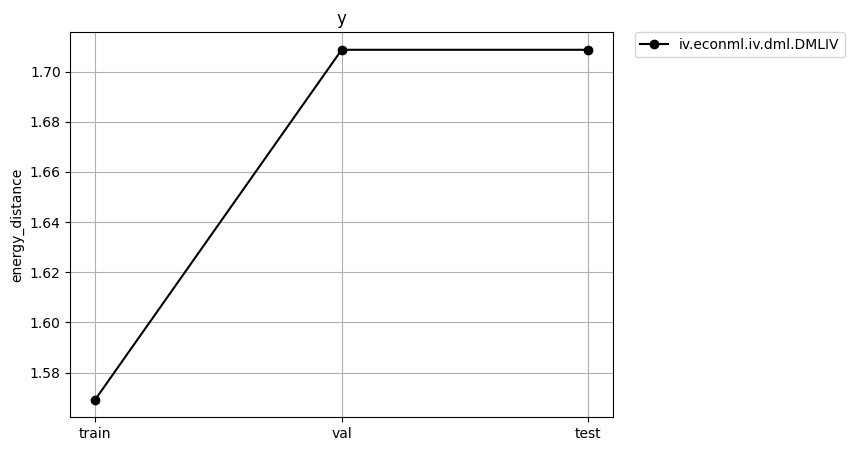

In [13]:
# Compare all estimator performance

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])


plt.figure(figsize = (7,5))
plt.title(outcome)

m1 = "energy_distance"

for (est, scr), col in zip(ct.scores.items(), colors):
    try:
        sc = [scr["scores"]['train'][m1], scr["scores"]['validation'][m1], scr["scores"]['test'][m1]]
        plt.plot(sc, color=col, marker="o", label=est)
        plt.xticks(np.arange(3), ['train', 'val', 'test'])

    except:
        pass

plt.ylabel(m1)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.grid()
plt.show()


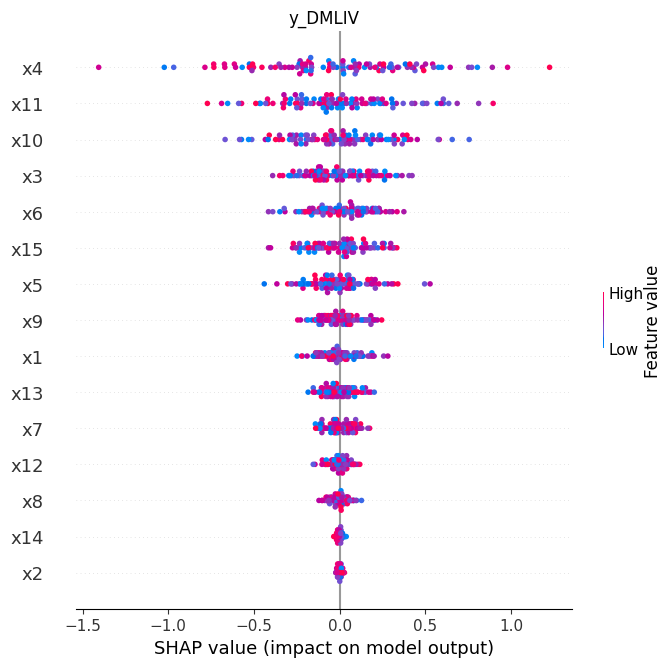

In [15]:
# Feature importance with SHAP explainer
import matplotlib.pyplot as plt
import shap

# and now let's visualize feature importances!
from causaltune.shap import shap_values

# Shapley values calculation can be slow so let's subsample
this_df = ct.test_df.sample(100)

scr = ct.scores[ct.best_estimator]
est = ct.model
shaps = shap_values(est, this_df)

plt.title(outcome + '_' + ct.best_estimator.split('.')[-1])
shap.summary_plot(shaps, this_df[cd.effect_modifiers])
plt.show()